# Notebook For Metric format dev and creation of RMS Metric

In [1]:
from brian2 import *
from brian2tools import *

prefs.codegen.target = 'cython'  # weave is not multiprocess-safe!

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]


In [2]:
# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
VT = -63*mV

dt = 0.01*ms

In [3]:
# Generate a step-current input and an "experimental" voltage trace
input_current = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt)), np.zeros(int(5*ms/dt))])*nA

In [4]:
np.shape(input_current)

(1497,)

In [5]:
params_correct = {'gl': float(5e-5*siemens*cm**-2 * area),
                  'g_na': float(100*msiemens*cm**-2 * area),
                  'g_kd': float(30*msiemens*cm**-2 * area)}

defaultclock.dt = dt

In [6]:
# The model
eqsHH = Equations('''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I(t))/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
g_na : siemens (constant)
g_kd : siemens (constant)
gl   : siemens (constant)
''')

In [7]:
I = TimedArray(input_current, dt=dt)

G = NeuronGroup(1, eqsHH, method='exponential_euler')
G.v = El
G.set_states(params_correct, units=False)
mon = StateMonitor(G, 'v', record=0)
run(20*ms)

voltage = mon.v[0]/mV
voltage += np.random.randn(len(voltage))


inp_trace = np.array([input_current])
n0, n1 = inp_trace.shape

out_trace = np.array([voltage[:n1]])

In [8]:
mon.v/mV

array([[-65.        , -65.        , -65.        , ..., -74.45678717,
        -74.45205975, -74.44733469]])

In [9]:
np.shape(out_trace[0])

(1497,)

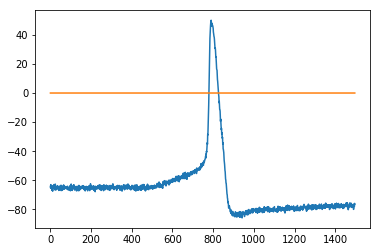

In [10]:
plot(out_trace[0]);
plot(inp_trace[0]);

In [11]:
out_trace

array([[-64.12507978, -65.2854209 , -62.92801224, ..., -77.93710147,
        -75.83074761, -76.32144711]])

In [12]:
inp_trace

array([[0., 0., 0., ..., 0., 0., 0.]])

In [13]:
# Model for modelfitting
eqs = Equations(
'''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
g_na : siemens (constant)
g_kd : siemens (constant)
gl   : siemens (constant)
''',
Cm=1*ufarad*cm**-2 * area, El=-65*mV, EK=-90*mV, ENa=50*mV, VT=-63*mV)

In [14]:
n_opt = NevergradOptimizer()

In [15]:
# pass parameters to the NeuronGroup
res, error, output_traces, errors = fit_traces_standalone(model=eqs, input_var='I', output_var='v',
                                   input=inp_trace * amp, output=out_trace*mV, dt=dt,
                                   gl=[1e-8*siemens*cm**-2 * area, 1e-4*siemens*cm**-2 * area],
                                   g_na=[1*msiemens*cm**-2 * area, 200*msiemens*cm**-2 * area],
                                   g_kd=[1*msiemens*cm**-2 * area, 100*msiemens*cm**-2 * area],
                                   n_rounds=2, n_samples=30, optimizer=n_opt,)

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'exponential_euler' (took 0.24s, trying other methods took 0.14s). [brian2.stateupdaters.base.method_choice]


In [16]:
np.shape(output_traces[0])

(30, 1497)

In [17]:
xx = output_traces[0]

In [18]:
xx

array([[ 0.00000000e+00, -4.99802821e-05, -9.99010034e-05, ...,
        -7.87499658e-02, -7.87393930e-02, -7.87288284e-02],
       [ 0.00000000e+00, -3.47342135e-05, -6.94487206e-05, ...,
        -8.33646621e-02, -8.33548485e-02, -8.33450402e-02],
       [ 0.00000000e+00, -4.66348453e-05, -9.32303842e-05, ...,
        -7.66166413e-02, -7.66083069e-02, -7.65999784e-02],
       ...,
       [ 0.00000000e+00, -3.71020174e-05, -7.41685809e-05, ...,
        -8.35862666e-02, -8.35756575e-02, -8.35650546e-02],
       [ 0.00000000e+00, -2.58712881e-05, -5.17285124e-05, ...,
        -8.02897843e-02, -8.02836987e-02, -8.02776155e-02],
       [ 0.00000000e+00, -3.39209503e-05, -6.78044397e-05, ...,
        -8.13523358e-02, -8.13438022e-02, -8.13352730e-02]])

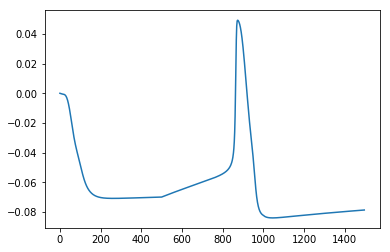

In [19]:
plt.plot(xx[0])

## Calculate RMS

In [20]:
xx.shape

(30, 1497)

In [21]:
y = out_trace[0]
y

array([-64.12507978, -65.2854209 , -62.92801224, ..., -77.93710147,
       -75.83074761, -76.32144711])

In [22]:
y.shape

(1497,)

In [74]:
from sklearn.metrics import mean_squared_error

rms_list, mse_list = [], []
for row in xx:
#     print(np.array(row))
    mse = mean_squared_error(y.transpose(), row.transpose())
    mse2 = (np.square(y - row))
#     rms = np.sqrt(mse)
    rms = mse
    rms_list.append(rms)
    mse_list.append(mse2)
    
    
#     print(mse, rms)
    

In [75]:
errors[0]

array([[0.        , 0.00410562, 0.00835477, ..., 1.51611421, 1.51611486,
        1.51612326],
       [0.        , 0.00410757, 0.0083607 , ..., 1.22780734, 1.22783669,
        1.22789315],
       [0.        , 0.00410605, 0.00835607, ..., 1.4035203 , 1.40352207,
        1.40352266],
       ...,
       [0.        , 0.00410727, 0.00835978, ..., 1.40921812, 1.40924991,
        1.40930973],
       [0.        , 0.00410871, 0.00836414, ..., 1.32800912, 1.32801463,
        1.3280344 ],
       [0.        , 0.00410768, 0.00836101, ..., 1.55980614, 1.55981774,
        1.55984804]])

In [76]:
np.shape(errors[0])

(30, 1497)

In [77]:
err = (errors[0])
err

array([[0.        , 0.00410562, 0.00835477, ..., 1.51611421, 1.51611486,
        1.51612326],
       [0.        , 0.00410757, 0.0083607 , ..., 1.22780734, 1.22783669,
        1.22789315],
       [0.        , 0.00410605, 0.00835607, ..., 1.4035203 , 1.40352207,
        1.40352266],
       ...,
       [0.        , 0.00410727, 0.00835978, ..., 1.40921812, 1.40924991,
        1.40930973],
       [0.        , 0.00410871, 0.00836414, ..., 1.32800912, 1.32801463,
        1.3280344 ],
       [0.        , 0.00410768, 0.00836101, ..., 1.55980614, 1.55981774,
        1.55984804]])

In [85]:
mse_list[0]

array([4112.0258562 , 4262.17965643, 3959.92215197, ..., 6061.92289948,
       5738.36674894, 5812.95209094])

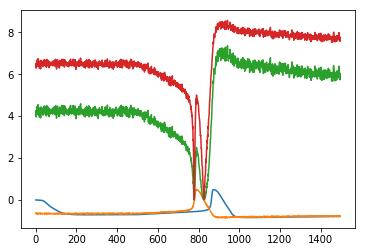

In [93]:
plot(output_traces[0][0]*10)
plot(y/100)
# plot(err[0])
plot(mse_list[0]/1000);
plot(np.sqrt(mse_list[0])/10);


In [47]:
err_mean = mean(err, axis=1)
(err_mean)

array([0.78227   , 0.59073461, 0.72178018, 0.74162514, 0.61634088,
       0.72983903, 0.66397722, 0.68065534, 0.78322317, 0.58868678,
       0.69597993, 0.71024466, 0.67315664, 0.75601839, 0.65611371,
       0.66681407, 0.70514597, 0.72542535, 0.69275433, 0.73241021,
       0.65735354, 0.66736607, 0.81669255, 0.70354075, 0.7368342 ,
       0.73309493, 0.68774546, 0.68069688, 0.66454232, 0.78695993])

In [51]:
np.array(rms_list)/1497

array([3.16964522, 3.16927102, 3.16982382, 3.16929221, 3.16929008,
       3.16936933, 3.16923974, 3.16931925, 3.16965238, 3.16933461,
       3.16941463, 3.16914754, 3.16916007, 3.16941293, 3.16957578,
       3.1692037 , 3.1695333 , 3.16931471, 3.16914166, 3.16923938,
       3.16920557, 3.16927753, 3.16952504, 3.16942178, 3.16926418,
       3.16933678, 3.1691872 , 3.16924268, 3.16962258, 3.16956078])